In [27]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import draw
from skimage import transform
sns.set_theme(style='whitegrid')
plt.rcParams["figure.figsize"] = (10,10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)



def polygon2mask(polygon):
    """
    Create an image mask from polygon coordinates
    """
    vertex_row_coords, vertex_col_coords, shape = polygon[:, 1], polygon[:, 0], (450, 600)
    
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=float)
    mask[fill_row_coords, fill_col_coords] = 1.
    mask = transform.resize(mask, (224, 224))
    return mask


def confidence_interval_correlation(data, size=10000, attribute='trust'):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = data.sample(data.shape[0], replace=True)
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = stats.spearmanr(bs_sample[attribute], bs_sample['overlap'])[0]
    
    return np.percentile(bs_replicates, [2.5, 97.5])

def confidence_interval(data, size=10000, func=np.mean):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return np.percentile(bs_replicates, [2.5, 97.5])


mel_class_labels = ['TRBL', 'BDG', 'WLSA', 'ESA', 'GP', 'PV', 'PRL']
nev_class_labels = ['APC', 'MS', 'OPC']
char_class_labels = mel_class_labels+nev_class_labels + ['PLR', 'PES', 'PIF', 'SPC', 'MVP', 'PRLC', 'PLF', 'PDES']

mappings = {
	'thick reticular or branched lines': 'TRBL',
	'dicke retikuläre oder verzweigte Linien': 'TRBL',

	'eccentrically located structureless area': 'ESA',
	'exzentrisch gelegenes, strukturloses Areal jeglicher Farbe, außer hautfarben, weiß und grau': 'ESA',

	'grey patterns': 'GP',
	'graue Muster': 'GP',

	'polymorphous vessels': 'PV',
	'polymorphe Gefäße': 'PV',

	'pseudopods or radial lines at the lesion margin that do not occupy the entire lesional circumference': 'PRL',
	'pseudopodien oder radiale Linien am Läsionsrand, die nicht den gesamten Läsionsumfang einnehmen': 'PRL',

	'black dots or globules in the periphery of the lesion': 'BDG',
	'schwarze Punkte oder Schollen in der Läsionsperipherie': 'BDG',

	'white lines or white structureless area': 'WLSA',
	'weiße Linien oder weißes strukturloses Areal': 'WLSA',

	'parallel lines on ridges (acral lesions only)': 'PLR',
	'parallele Linien auf den Leisten (nur akrale Läsionen)': 'PLR',

	'pigmentation extends beyond the area of the scar (only after excision)': 'PES',
	'pigmentierung überschreitet Narbenareal (nur nach Entfernung)': 'PES',

	'pigmentation invades the openings of hair follicles (facial lesions)': 'PIF',
	'pigmentierung überschreitet Follikelöffnung (Gesichtsläsionen)': 'PIF',

	'only one pattern and only one colour': 'OPC',
	'nur ein Muster und nur eine Farbe': 'OPC',

	'symmetrical combination of patterns and;or colours': 'SPC',
	'symmetrische Kombination von Mustern und;oder Farben': 'SPC',

	'monomorphic vascular pattern': 'MVP',
	'monomorphes Gefäßmuster': 'MVP',

	'pseudopods or radial lines at the lesional margin involving the entire lesional circumference': 'PRLC',
	'pseudopodien oder radiale Linien am Läsionsrand über den gesamten Läsionsumfang': 'PRLC',

	'parallel lines in the furrows (acral lesions only)': 'PLF',
	'parallele Linien in den Furchen (nur akrale Läsionen)': 'PLF',

	'pigmentation does not extend beyond the area of the scar (only after excision)': 'PDES',
	'pigmentierung überschreitet Narbe nicht (nur nach Entfernung)': 'PDES',

	'asymmetric combination of multiple patterns or colours in the absence of other melanoma criteria': 'APC',
	'asymmetrische Kombination mehrerer Muster und;oder Farben ohne weitere Melanomkriterien': 'APC',

	'melanoma simulator': 'MS',
	'melanomsimulator': 'MS',
    
	'please select at least one explanation': 'XX',
	'bitte wählen Sie mindestens eine Erklärung aus.': 'XX',
    'andere (bitte angeben)': 'XX'
}


corpus = char_class_labels
vectorizer = CountVectorizer()
vectorizer.fit(corpus)

predictions_path = "/home/kti01/Documents/My Files/Projects/Overlap/characteristics_classifier/attributions"
phase1_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase1"
phase3_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase3"
phase2_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase2"
metadata_phase1 = pd.read_pickle(os.path.join(phase1_path, "metadata_phase1.pkl")).drop_duplicates(subset=['participant', 'image_id', 'group'])
metadata_phase3 = pd.read_csv(os.path.join(phase3_path, "metadata_phase3.csv"))
metadata_phase3 = metadata_phase3[~metadata_phase3.issues.isin(['Insufficient Image Quality', 'unzureichende Bildqualität'])]

metadata_phase1['prediction'] = np.floor(metadata_phase1['prediction'])
metadata_phase3['prediction'] = np.floor(metadata_phase3['prediction'])

In [28]:
drop = ['e21', 'e41', 'e70', 'e87', 'g71']
dice_list = []
for mask in metadata_phase1['mask'].unique():
    df = metadata_phase1[metadata_phase1['mask']==mask].drop_duplicates(subset='participant')
    #df = df[~df.participant.isin(drop)]
    doc_pred = df[char_class_labels]
    #doc_pred = doc_pred.sample(2)
    doc_pred = doc_pred.fillna(0)
    mappings = {-1 : 0, 0: 0, 1: 1}
    for col in doc_pred.columns:
        doc_pred[col] = doc_pred[col].map(mappings)

    for i in range(len(doc_pred)):
        for j in range(i+1, len(doc_pred)):
            if i != j:
                #if np.floor(df.iloc[i].prediction) == np.floor(df.iloc[j].prediction):
                    a = doc_pred.iloc[i]
                    b = doc_pred.iloc[j]
                    if a.sum() > 0 and b.sum() > 0:
                        dice = metrics.f1_score(a, b)
                        dice_list.append(dice)


In [29]:
clinician_agreement_df = pd.DataFrame({'overlap': dice_list})
print(clinician_agreement_df.overlap.mean())
print(confidence_interval(clinician_agreement_df.overlap))
print(clinician_agreement_df.shape)

0.27896905718783743
[0.268899   0.28879626]
(5165, 1)


<AxesSubplot:>

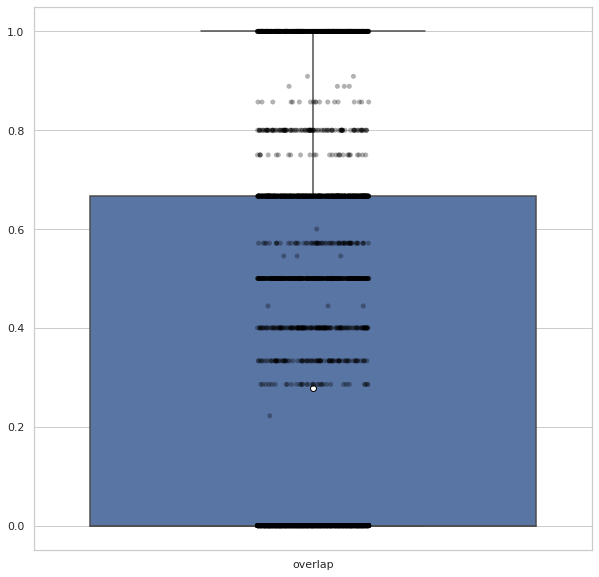

In [30]:
sns.boxplot(data=clinician_agreement_df, showfliers=False, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black", "markersize":"6"})
sns.stripplot(data=clinician_agreement_df, color='black', alpha=.3)

In [31]:
nums = []
for idx, row in metadata_phase1[char_class_labels].iterrows():
    num = (row == 1).sum()
    nums.append(num)
np.mean(nums)

1.6057692307692308

# Agreement per feature

In [32]:
drop = ['e21', 'e41', 'e70', 'e87', 'g71']
agreement_dict = {}
for mask in metadata_phase1['mask'].unique():
    df = metadata_phase1[metadata_phase1['mask']==mask].drop_duplicates(subset='participant')
    df = df[~df.participant.isin(drop)]
    doc_pred = df[char_class_labels]
    #doc_pred = doc_pred.sample(2)
    doc_pred = doc_pred.fillna(0)
    mappings = {-1 : 0, 0: 0, 1: 1}
    for col in doc_pred.columns:
        doc_pred[col] = doc_pred[col].map(mappings)

    for col in doc_pred.columns:
        perc_agreement = doc_pred[col].sum() / len(doc_pred[col])
        if col not in agreement_dict:
            agreement_dict[col] = []
        agreement_dict[col].append(perc_agreement)

In [33]:
agreement_df = pd.DataFrame(agreement_dict)
agreement_df.mean().sort_values()

PDES    0.004533
PLR     0.004823
PES     0.008048
PLF     0.015411
MVP     0.022408
PIF     0.029304
PRLC    0.047236
PV      0.072775
PRL     0.094479
TRBL    0.105390
MS      0.105908
OPC     0.116950
BDG     0.133433
GP      0.148824
WLSA    0.155141
APC     0.170147
SPC     0.191430
ESA     0.216954
dtype: float64

# Between-clinician and clinician-XAI ROI overlap

In [34]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import draw
from skimage import transform
sns.set_theme(style='whitegrid')
plt.rcParams["figure.figsize"] = (10,10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)



def polygon2mask(polygon):
    """
    Create an image mask from polygon coordinates
    """
    vertex_row_coords, vertex_col_coords, shape = polygon[:, 1], polygon[:, 0], (450, 600)
    
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=float)
    mask[fill_row_coords, fill_col_coords] = 1.
    mask = transform.resize(mask, (224, 224))
    return mask


def confidence_interval_correlation(data, size=10000, attribute='trust'):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = data.sample(data.shape[0], replace=True)
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = stats.spearmanr(bs_sample[attribute], bs_sample['overlap'])[0]
    
    return np.percentile(bs_replicates, [2.5, 97.5])

def confidence_interval(data, size=10000, func=np.mean):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    np.random.seed(42)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return np.percentile(bs_replicates, [2.5, 97.5])


mel_class_labels = ['TRBL', 'BDG', 'WLSA', 'ESA', 'GP', 'PV', 'PRL']
nev_class_labels = ['APC', 'MS', 'OPC']
char_class_labels = mel_class_labels+nev_class_labels + ['PLR', 'PES', 'PIF', 'SPC', 'MVP', 'PRLC', 'PLF', 'PDES']

mappings = {
	'thick reticular or branched lines': 'TRBL',
	'dicke retikuläre oder verzweigte Linien': 'TRBL',

	'eccentrically located structureless area': 'ESA',
	'exzentrisch gelegenes, strukturloses Areal jeglicher Farbe, außer hautfarben, weiß und grau': 'ESA',

	'grey patterns': 'GP',
	'graue Muster': 'GP',

	'polymorphous vessels': 'PV',
	'polymorphe Gefäße': 'PV',

	'pseudopods or radial lines at the lesion margin that do not occupy the entire lesional circumference': 'PRL',
	'pseudopodien oder radiale Linien am Läsionsrand, die nicht den gesamten Läsionsumfang einnehmen': 'PRL',

	'black dots or globules in the periphery of the lesion': 'BDG',
	'schwarze Punkte oder Schollen in der Läsionsperipherie': 'BDG',

	'white lines or white structureless area': 'WLSA',
	'weiße Linien oder weißes strukturloses Areal': 'WLSA',

	'parallel lines on ridges (acral lesions only)': 'PLR',
	'parallele Linien auf den Leisten (nur akrale Läsionen)': 'PLR',

	'pigmentation extends beyond the area of the scar (only after excision)': 'PES',
	'pigmentierung überschreitet Narbenareal (nur nach Entfernung)': 'PES',

	'pigmentation invades the openings of hair follicles (facial lesions)': 'PIF',
	'pigmentierung überschreitet Follikelöffnung (Gesichtsläsionen)': 'PIF',

	'only one pattern and only one colour': 'OPC',
	'nur ein Muster und nur eine Farbe': 'OPC',

	'symmetrical combination of patterns and;or colours': 'SPC',
	'symmetrische Kombination von Mustern und;oder Farben': 'SPC',

	'monomorphic vascular pattern': 'MVP',
	'monomorphes Gefäßmuster': 'MVP',

	'pseudopods or radial lines at the lesional margin involving the entire lesional circumference': 'PRLC',
	'pseudopodien oder radiale Linien am Läsionsrand über den gesamten Läsionsumfang': 'PRLC',

	'parallel lines in the furrows (acral lesions only)': 'PLF',
	'parallele Linien in den Furchen (nur akrale Läsionen)': 'PLF',

	'pigmentation does not extend beyond the area of the scar (only after excision)': 'PDES',
	'pigmentierung überschreitet Narbe nicht (nur nach Entfernung)': 'PDES',

	'asymmetric combination of multiple patterns or colours in the absence of other melanoma criteria': 'APC',
	'asymmetrische Kombination mehrerer Muster und;oder Farben ohne weitere Melanomkriterien': 'APC',

	'melanoma simulator': 'MS',
	'melanomsimulator': 'MS',
    
	'please select at least one explanation': 'XX',
	'bitte wählen Sie mindestens eine Erklärung aus.': 'XX',
    'andere (bitte angeben)': 'XX'
}


corpus = char_class_labels
vectorizer = CountVectorizer()
vectorizer.fit(corpus)

predictions_path = "/home/kti01/Documents/My Files/Projects/Overlap/characteristics_classifier/attributions"
phase1_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase1"
phase3_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase3"
phase2_path = "/home/kti01/Documents/My Files/Projects/Overlap/data/phase2"
metadata_phase1 = pd.read_pickle(os.path.join(phase1_path, "metadata_phase1.pkl")).drop_duplicates(subset=['participant', 'mask'])
metadata_phase3 = pd.read_csv(os.path.join(phase3_path, "metadata_phase3.csv"))
metadata_phase3 = metadata_phase3[~metadata_phase3.issues.isin(['Insufficient Image Quality', 'unzureichende Bildqualität'])]

metadata_phase1['prediction'] = np.floor(metadata_phase1['prediction'])
metadata_phase3['prediction'] = np.floor(metadata_phase3['prediction'])

overlaps = []
participants = []
masks = []
doc_preds = []
ai_preds = []
trusts = []
predictions = []


for idx, row in metadata_phase1.iterrows():
    
    if row.participant in ['e21', 'e41', 'e70', 'e87', 'g71']:
        continue
    
    mask = str(int(row['mask']))
    ai_pred = pd.read_csv(os.path.join(predictions_path, mask, 'predictions_'+mask+'.csv'))
    ai_pred = list(ai_pred[ai_pred['confidence'].isin(['strong', 'some'])]['label'])
    #ai_pred = list(ai_pred[ai_pred['confidence'] != 'low']['label'])
    if len(ai_pred) == 0:
        ai_pred = pd.read_csv(os.path.join(predictions_path, mask, 'predictions_'+mask+'.csv'))
        ai_pred = list(ai_pred['label'])
    ai_pred = [mappings[pred] for pred in ai_pred]
    
    # Select only the characteristics that the doctor predicted.
    doc_pred = row[char_class_labels]
    doc_pred = list(doc_pred[doc_pred == 1].index)

    if len(doc_pred) == 0:
        continue

    doc_preds.append(doc_pred)
    ai_preds.append(ai_pred)

    ai_pred = vectorizer.transform([' '.join(ai_pred)]).toarray()[0]
    doc_pred = vectorizer.transform([' '.join(doc_pred)]).toarray()[0]

    jacc = metrics.jaccard_score(doc_pred, ai_pred)
    dice = metrics.f1_score(doc_pred, ai_pred)
    ov = (ai_pred*doc_pred).sum()/min(ai_pred.sum(), doc_pred.sum())

    overlap = dice
    
    overlaps.append(overlap)
    participants.append(row['participant'])
    masks.append(row['mask'])
    predictions.append(row['prediction'])
    

overlap_df = pd.DataFrame({'participant': participants, 'mask': masks, 'overlap': overlaps,
                          'doc_pred': doc_preds, 'ai_pred': ai_preds, 'prediction_phase1': predictions})
overlap_df = pd.merge(overlap_df, metadata_phase3,  how='left', left_on=['participant','mask'], right_on =['participant','mask']).dropna()

"""
If phase 3 prediction is different from phase 1, drop the instance since it cant be used for overlap calculation
"""
overlap_df = overlap_df[overlap_df.prediction_phase1 == overlap_df.prediction]
overlap_df['same_as_ai'] = (overlap_df.prediction == overlap_df.AI_prediction).astype(int)
#overlap_df = overlap_df[overlap_df['same_as_ai'] == 1]
df = overlap_df[overlap_df.prediction.isin([0, 1])]
print(df.overlap.mean())
print(confidence_interval(df.overlap))
print(df.shape)
human_machine_agreement_df = df[['participant', 'overlap']].copy()

0.26880874456632037
[0.24991337 0.28835792]
(1089, 16)


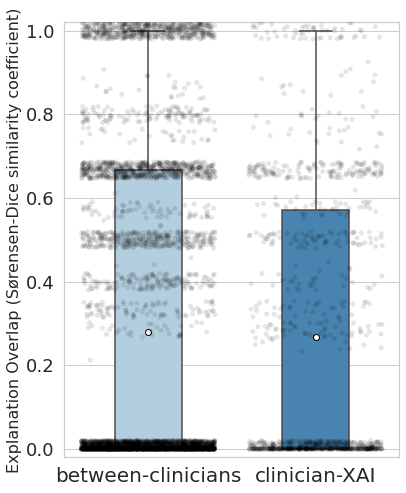

In [36]:
df = pd.concat([
    clinician_agreement_df.rename({'overlap': 'between-clinicians'}, axis=1),
    human_machine_agreement_df.rename({'overlap': 'clinician-XAI'}, axis=1)
], ignore_index=True)[['between-clinicians', 'clinician-XAI']].melt().dropna().rename({'value': 'overlap'}, axis=1)


plt.figure(figsize=(6,8))
sns.boxplot(data=df, x='variable', y='overlap', width=0.4, palette='Blues', showfliers=False, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", 
                                                                    "markeredgecolor":"black", "markersize":"6"})


source_data = df.copy()
df['overlap'] = df['overlap'] + np.random.uniform(-0.02, 0.02, size=len(df))
df['overlap'] = df['overlap'].apply(lambda x: max(0, min(x, 10)))


sns.stripplot(data=df, x='variable', y='overlap', color='black', alpha=0.1, jitter=0.4)
plt.yticks(size=18)
plt.xticks(size=20)
plt.ylim(-0.02, 1.02)
plt.xlabel('')
plt.ylabel('Explanation Overlap (Sørensen-Dice similarity coefficient)', size=16)
plt.savefig('/home/kti01/Documents/My Files/Projects/Overlap/plots/overlap/overlap.pdf', dpi=500, bbox_inches='tight')

In [87]:
#df.to_csv('../Source Data/Fig3b.csv', index=False)

In [103]:
df = pd.read_csv("/home/kti01/Documents/My Files/Projects/Overlap/reproduce/data/classifier/result_test_resnet50")
df = df[['image_id', 'benign_malignant', 'prediction']]
df.to_csv("/home/kti01/Documents/My Files/Projects/Overlap/reproduce/data/figshare/result_our_xai.csv", index=False)

In [ ]:
metrics.balanced_accuracy_score(df.benign_malignant, df.prediction)

In [ ]:

df = pd.read_csv("/home/kti01/Documents/My Files/Projects/Overlap/reproduce/data/baseline/result_test_resnet50.csv")
metrics.balanced_accuracy_score(df.true, df.pred)